In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [6]:
file_path = 'train.csv' 
data = pd.read_csv(file_path,low_memory=False)

In [7]:
def convert_dates(df):
    # Splitting the DataFrame based on the format found in unique values
    format1_mask = df['DATE (MM/DD)'].str.contains('-', na=False) & df['DATE (MM/DD)'].str.split('-').str[0].str.isdigit()
    format2_mask = ~format1_mask & df['DATE (MM/DD)'].notna()
    
    # Convert dates with '01-Jan' format
    df.loc[format1_mask, 'Formatted Date'] = pd.to_datetime(df.loc[format1_mask, 'DATE (MM/DD)'] + '-2020', format='%d-%b-%Y')
    
    # Convert dates with 'Jan-13' format
    df.loc[format2_mask, 'Formatted Date'] = pd.to_datetime(df.loc[format2_mask, 'DATE (MM/DD)'] + '-2020', format='%b-%d-%Y')
    
    return df
# Apply the conversion function
data = convert_dates(data)

# Sort the DataFrame by the 'Formatted Date' in ascending order
sorted_data = data.sort_values('Formatted Date')
sorted_data = sorted_data.dropna(subset=['DATE (MM/DD)'])

In [8]:
sorted_data.dtypes
sorted_data.isnull().sum()

DATE (MM/DD)                                0
MST                                         0
Global CMP22 (vent/cor) [W/m^2]             0
Direct sNIP [W/m^2]                         0
Azimuth Angle [degrees]                     0
Tower Dry Bulb Temp [deg C]                 0
Tower Wet Bulb Temp [deg C]                 0
Tower Dew Point Temp [deg C]                0
Tower RH [%]                                0
Total Cloud Cover [%]                    1469
Peak Wind Speed @ 6ft [m/s]                 0
Avg Wind Direction @ 6ft [deg from N]       0
Station Pressure [mBar]                     0
Precipitation (Accumulated) [mm]            0
Snow Depth [cm]                             0
Moisture                                    0
Albedo (CMP11)                              0
Formatted Date                              0
dtype: int64

In [9]:
sorted_data = sorted_data.copy()
sorted_data['Formatted Date'] = sorted_data['Formatted Date'].astype(str)
sorted_data['MST'] = sorted_data['MST'].astype(str)

sorted_data['Datetime'] = pd.to_datetime(sorted_data['Formatted Date'] + ' ' + sorted_data['MST'])

# Sort the data by the new datetime column
sorted_data_1 = sorted_data.sort_values(by='Datetime')

In [10]:
data = sorted_data_1.copy()
data

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11),Formatted Date,Datetime
0,01-Jan,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,0.0,9.95,271.3,806.779,0.0,0.219,0.0,0.0,2020-01-01,2020-01-01 00:00:00
1,01-Jan,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,0.0,8.20,272.9,806.840,0.0,0.206,0.0,0.0,2020-01-01,2020-01-01 00:01:00
2,01-Jan,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,0.0,6.70,288.8,806.876,0.0,0.148,0.0,0.0,2020-01-01,2020-01-01 00:02:00
3,01-Jan,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,0.0,7.70,294.0,806.823,0.0,0.235,0.0,0.0,2020-01-01,2020-01-01 00:03:00
4,01-Jan,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,0.0,7.20,285.5,806.762,0.0,0.182,0.0,0.0,2020-01-01,2020-01-01 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482395,Nov-30,23:55,-1.430090,-0.098754,3.91898,6.093,-1.134,-14.734,17.95,0.0,2.70,287.9,812.627,0.0,0.163,0.0,0.0,2020-11-30,2020-11-30 23:55:00
482396,Nov-30,23:56,-1.423050,-0.153069,4.67193,6.035,-1.314,-15.614,16.61,0.0,3.20,293.2,812.623,0.0,0.262,0.0,0.0,2020-11-30,2020-11-30 23:56:00
482397,Nov-30,23:57,-1.366740,-0.098754,5.42370,6.207,-1.326,-16.126,15.65,0.0,2.70,292.1,812.616,0.0,0.359,0.0,0.0,2020-11-30,2020-11-30 23:57:00
482398,Nov-30,23:58,-1.353470,-0.044439,6.17411,6.357,-1.097,-15.297,16.73,0.0,2.95,294.7,812.614,0.0,0.172,0.0,0.0,2020-11-30,2020-11-30 23:58:00


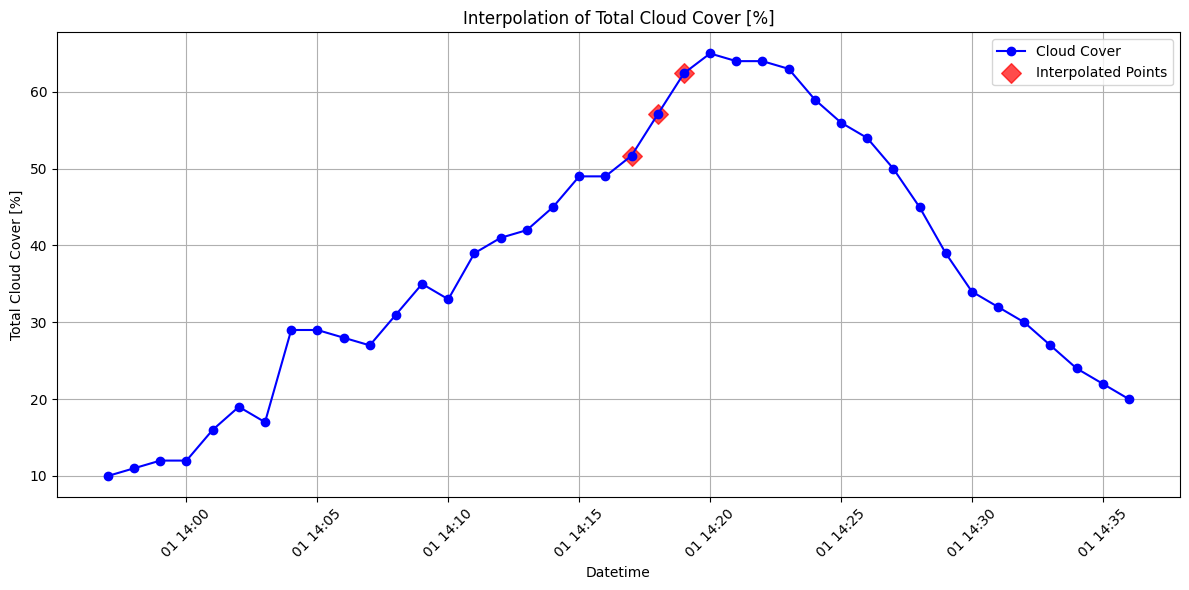

In [11]:
nan_indices_before = data['Total Cloud Cover [%]'].isna()
data['Total Cloud Cover [%]'] = data['Total Cloud Cover [%]'].interpolate(method='cubic')
nan_indices_after = data['Total Cloud Cover [%]'].isna()
filled_indices = nan_indices_before & ~nan_indices_after
first_filled_index = filled_indices.idxmax()
window_size = 20
start_index = max(0, first_filled_index - window_size)
end_index = min(len(data) - 1, first_filled_index + window_size)
#Create the plot
# Plotting all data points for 'Total Cloud Cover [%]'
plt.figure(figsize=(12, 6))
plt.plot(data['Datetime'].iloc[start_index:end_index], data['Total Cloud Cover [%]'].iloc[start_index:end_index], marker='o', linestyle='-', label='Cloud Cover', color='blue')

# Highlighting interpolated points
# Increase marker size with 's=50', use a different marker shape like 'd' (thin diamond), and adjust opacity with 'alpha=0.7' for visibility
plt.scatter(data['Datetime'].iloc[start_index:end_index][filled_indices[start_index:end_index]],
            data['Total Cloud Cover [%]'].iloc[start_index:end_index][filled_indices[start_index:end_index]], 
            color='red', s=100, marker='D', alpha=0.7, label='Interpolated Points')

plt.title('Interpolation of Total Cloud Cover [%]')
plt.xlabel('Datetime')
plt.ylabel('Total Cloud Cover [%]')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [12]:
data.isnull().sum(axis=0)

DATE (MM/DD)                             0
MST                                      0
Global CMP22 (vent/cor) [W/m^2]          0
Direct sNIP [W/m^2]                      0
Azimuth Angle [degrees]                  0
Tower Dry Bulb Temp [deg C]              0
Tower Wet Bulb Temp [deg C]              0
Tower Dew Point Temp [deg C]             0
Tower RH [%]                             0
Total Cloud Cover [%]                    0
Peak Wind Speed @ 6ft [m/s]              0
Avg Wind Direction @ 6ft [deg from N]    0
Station Pressure [mBar]                  0
Precipitation (Accumulated) [mm]         0
Snow Depth [cm]                          0
Moisture                                 0
Albedo (CMP11)                           0
Formatted Date                           0
Datetime                                 0
dtype: int64

In [13]:
data

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11),Formatted Date,Datetime
0,01-Jan,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,0.0,9.95,271.3,806.779,0.0,0.219,0.0,0.0,2020-01-01,2020-01-01 00:00:00
1,01-Jan,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,0.0,8.20,272.9,806.840,0.0,0.206,0.0,0.0,2020-01-01,2020-01-01 00:01:00
2,01-Jan,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,0.0,6.70,288.8,806.876,0.0,0.148,0.0,0.0,2020-01-01,2020-01-01 00:02:00
3,01-Jan,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,0.0,7.70,294.0,806.823,0.0,0.235,0.0,0.0,2020-01-01,2020-01-01 00:03:00
4,01-Jan,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,0.0,7.20,285.5,806.762,0.0,0.182,0.0,0.0,2020-01-01,2020-01-01 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482395,Nov-30,23:55,-1.430090,-0.098754,3.91898,6.093,-1.134,-14.734,17.95,0.0,2.70,287.9,812.627,0.0,0.163,0.0,0.0,2020-11-30,2020-11-30 23:55:00
482396,Nov-30,23:56,-1.423050,-0.153069,4.67193,6.035,-1.314,-15.614,16.61,0.0,3.20,293.2,812.623,0.0,0.262,0.0,0.0,2020-11-30,2020-11-30 23:56:00
482397,Nov-30,23:57,-1.366740,-0.098754,5.42370,6.207,-1.326,-16.126,15.65,0.0,2.70,292.1,812.616,0.0,0.359,0.0,0.0,2020-11-30,2020-11-30 23:57:00
482398,Nov-30,23:58,-1.353470,-0.044439,6.17411,6.357,-1.097,-15.297,16.73,0.0,2.95,294.7,812.614,0.0,0.172,0.0,0.0,2020-11-30,2020-11-30 23:58:00


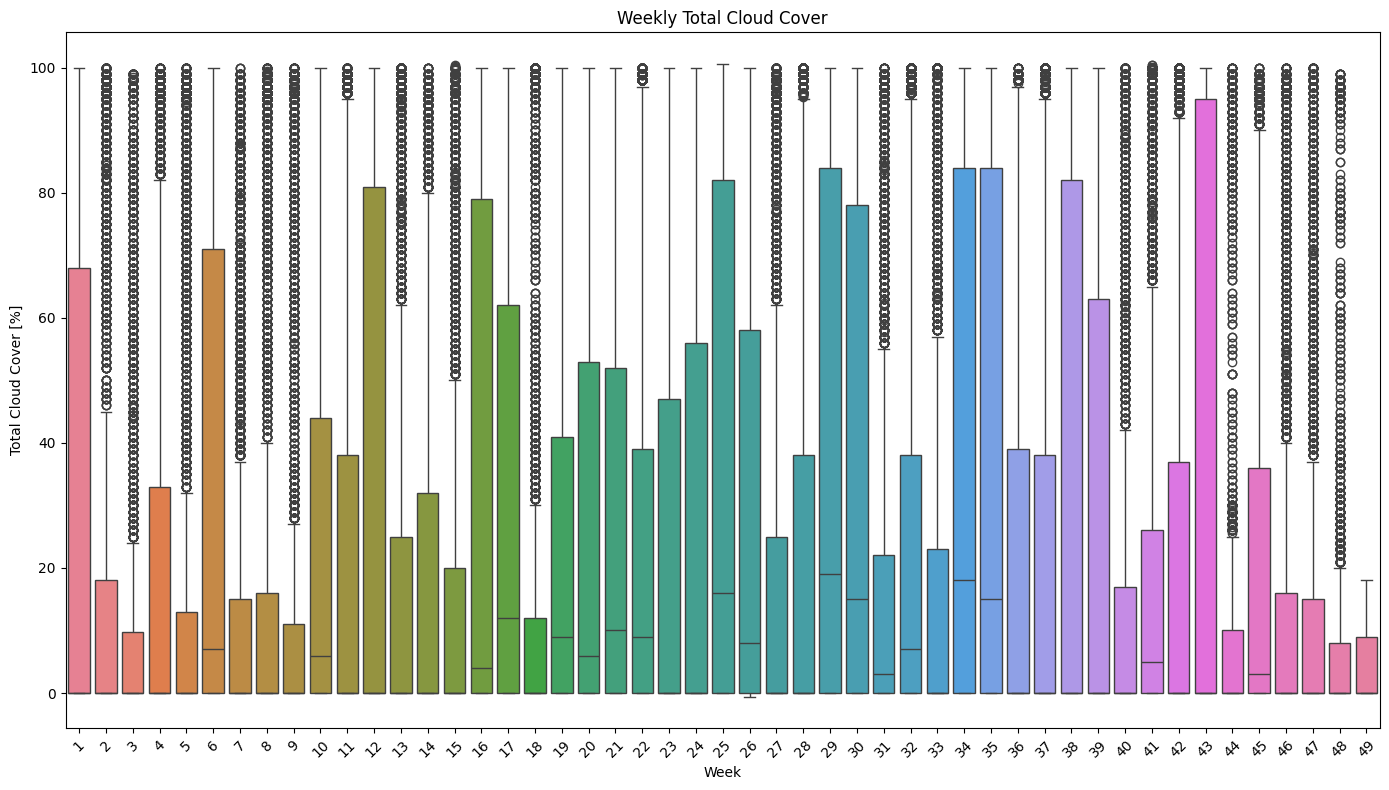

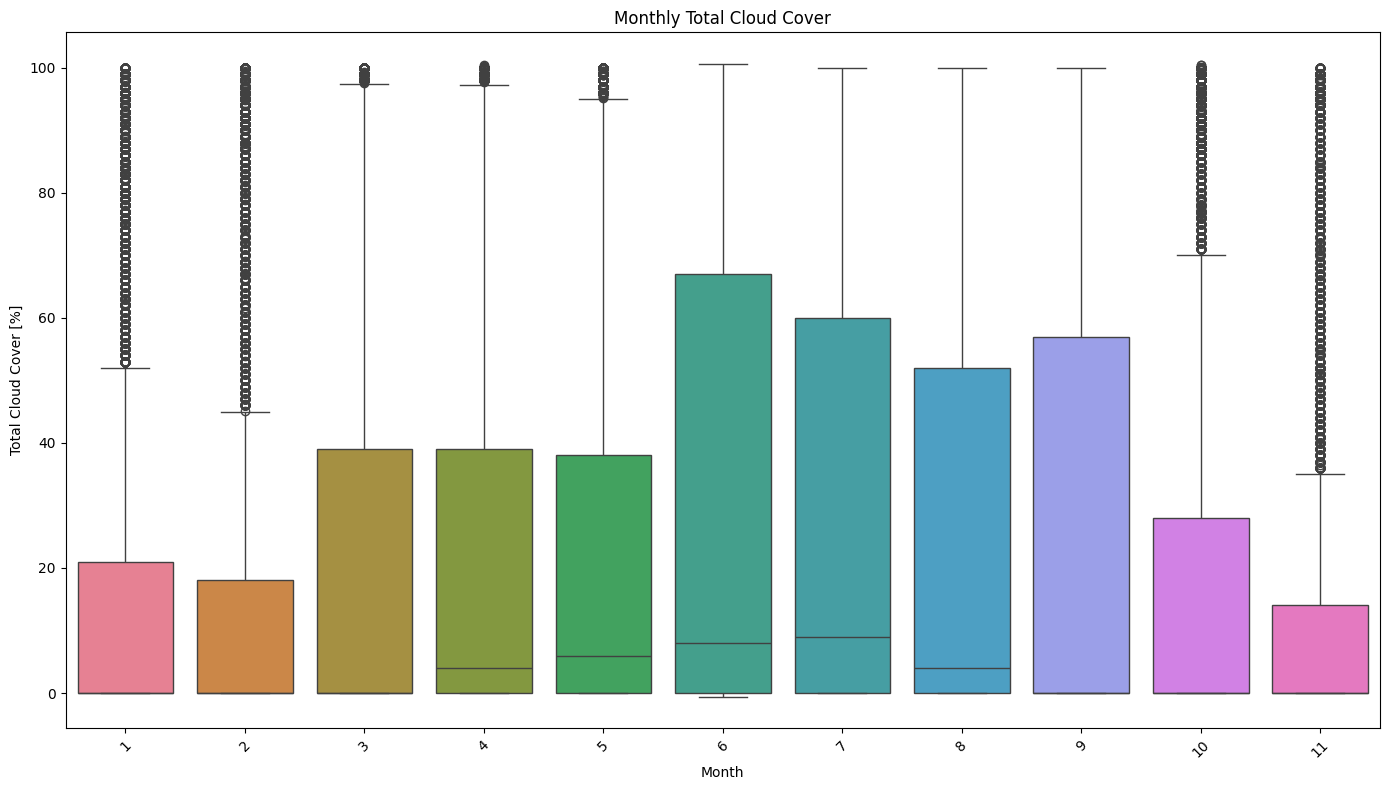

In [14]:
# Extract week and month from the datetime
data['Week'] = data['Datetime'].dt.isocalendar().week.astype(int)
data['Month'] = data['Datetime'].dt.month

# Reset index to make 'Datetime' available as a column
data_reset = data.reset_index()

# Generate a large number of colors for the palette
week_palette = sns.color_palette("husl", data['Week'].nunique())
month_palette = sns.color_palette("husl", data['Month'].nunique())

# Weekly box plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Week', y='Total Cloud Cover [%]', hue='Week', data=data_reset, palette=week_palette, dodge=False)
plt.title('Weekly Total Cloud Cover')
plt.xlabel('Week')
plt.ylabel('Total Cloud Cover [%]')
plt.legend([], [], frameon=False)  # Remove legend
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.show()

# Monthly box plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Month', y='Total Cloud Cover [%]', hue='Month', data=data_reset, palette=month_palette, dodge=False)
plt.title('Monthly Total Cloud Cover')
plt.xlabel('Month')
plt.ylabel('Total Cloud Cover [%]')
plt.legend([], [], frameon=False)  # Remove legend
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.show()




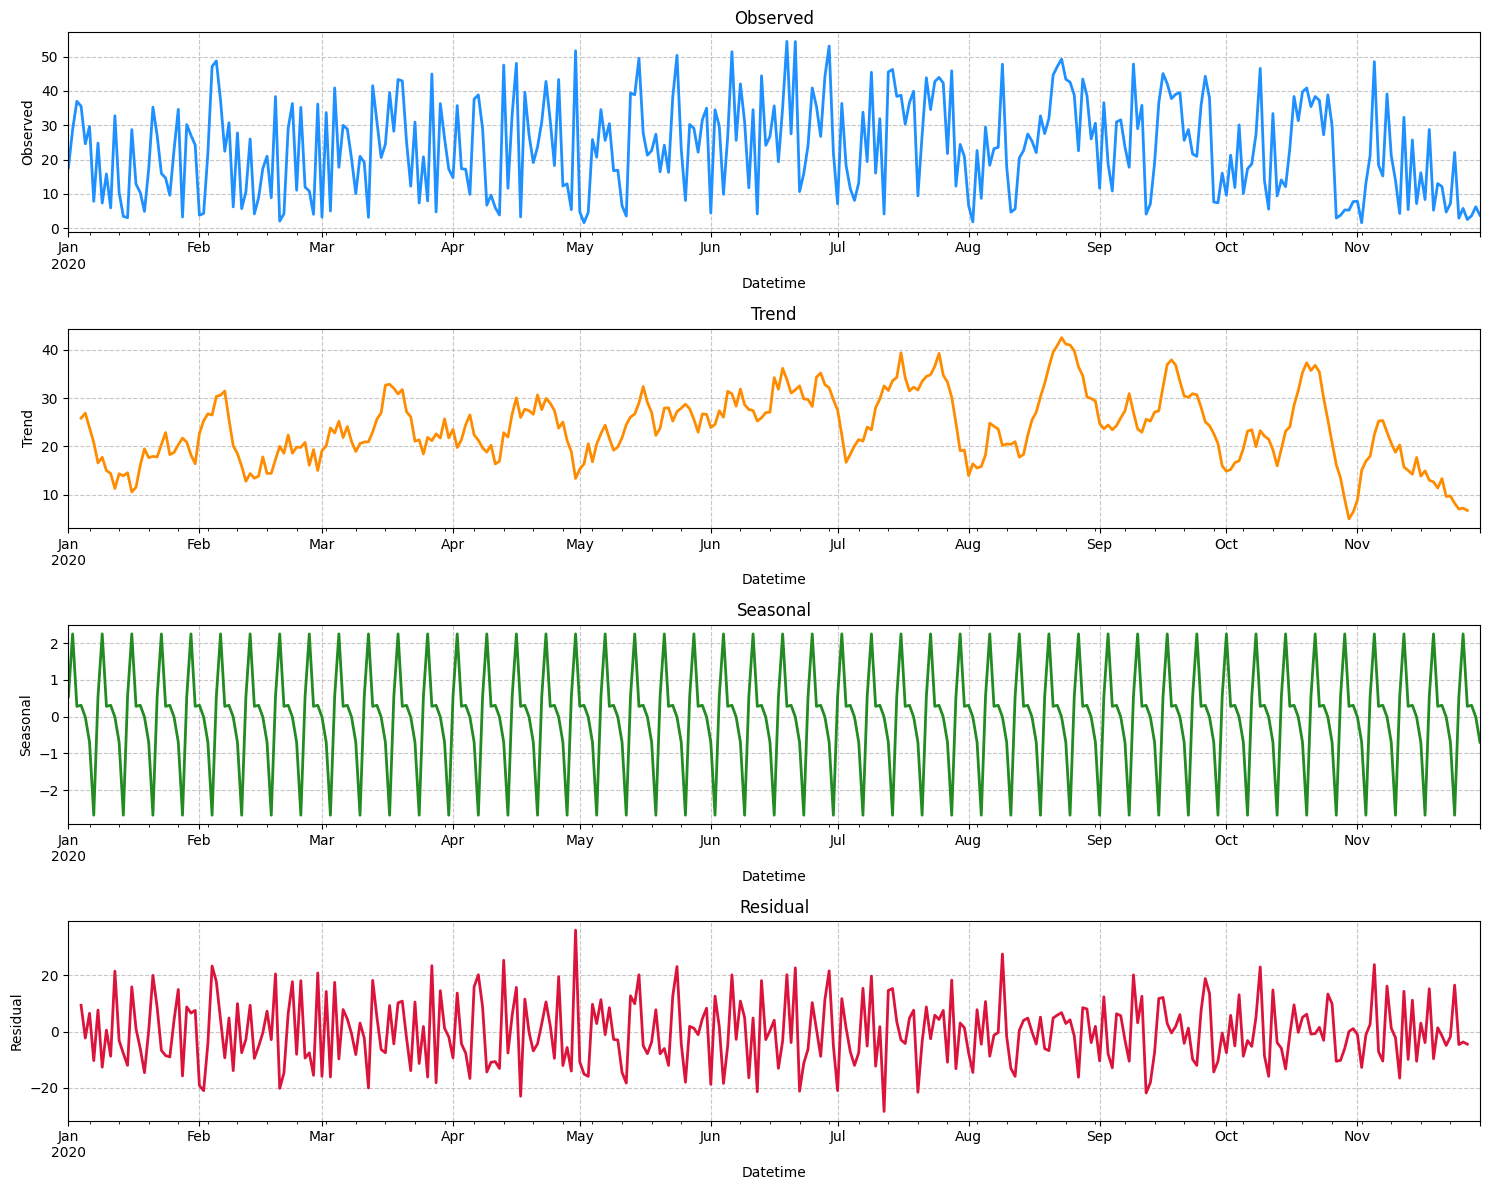

In [15]:


# Set 'Datetime' as the index
data.set_index('Datetime', inplace=True)

# Resample the data to daily averages
daily_data = data['Total Cloud Cover [%]'].resample('D').mean()

# Perform seasonal decomposition with a specified period of 7 days (weekly seasonality)
weekly_period = 7
decomposition = seasonal_decompose(daily_data, model='additive', period=weekly_period)

data.reset_index(inplace=True)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

# Observed
decomposition.observed.plot(ax=ax1, color='dodgerblue', linewidth=2)
ax1.set_ylabel('Observed')
ax1.set_title('Observed')
ax1.grid(True, linestyle='--', alpha=0.7)

# Trend
decomposition.trend.plot(ax=ax2, color='darkorange', linewidth=2)
ax2.set_ylabel('Trend')
ax2.set_title('Trend')
ax2.grid(True, linestyle='--', alpha=0.7)

# Seasonal
decomposition.seasonal.plot(ax=ax3, color='forestgreen', linewidth=2)
ax3.set_ylabel('Seasonal')
ax3.set_title('Seasonal')
ax3.grid(True, linestyle='--', alpha=0.7)

# Residual
decomposition.resid.plot(ax=ax4, color='crimson', linewidth=2)
ax4.set_ylabel('Residual')
ax4.set_title('Residual')
ax4.grid(True, linestyle='--', alpha=0.7)

# Formatting the x-axis to improve readability
plt.tight_layout()
plt.show()


In [16]:
# Calculate the sine and cosine components of the azimuth angles
data['sin_azimuth'] = np.sin(np.radians(data['Azimuth Angle [degrees]']))
data['cos_azimuth'] = np.cos(np.radians(data['Azimuth Angle [degrees]']))

# Display the new columns to verify
data[['Azimuth Angle [degrees]', 'sin_azimuth', 'cos_azimuth']].head()

,Azimuth Angle [degrees],sin_azimuth,cos_azimuth
0,356.85640,-0.054839,0.998495
1,357.65505,-0.040916,0.999163
2,358.45438,-0.026973,0.999636
3,359.25416,-0.013017,0.999915
4,0.05415,0.000945,1.000000


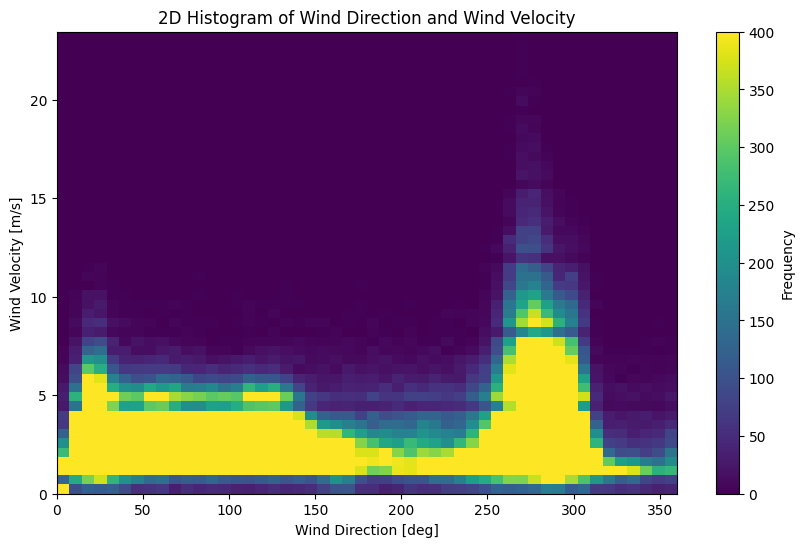

In [17]:
wind_direction = data['Avg Wind Direction @ 6ft [deg from N]']
wind_speed = data['Peak Wind Speed @ 6ft [m/s]']

# Create a 2D histogram
plt.figure(figsize=(10, 6))
plt.hist2d(wind_direction, wind_speed, bins=(50, 50), vmax=400, cmap='viridis')
plt.colorbar(label='Frequency')
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
plt.title('2D Histogram of Wind Direction and Wind Velocity')
plt.show()

In [18]:
# Extract the columns
peak_wind_speed = data['Peak Wind Speed @ 6ft [m/s]']
avg_wind_direction = data['Avg Wind Direction @ 6ft [deg from N]']

# Convert wind direction to radians
avg_wind_direction_rad = avg_wind_direction * np.pi / 180

# Calculate the wind x and y components
data['max Wx'] = peak_wind_speed * np.cos(avg_wind_direction_rad)
data['max Wy'] = peak_wind_speed * np.sin(avg_wind_direction_rad)

# Display the new columns to verify
data[['Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]', 'max Wx', 'max Wy']].head()

,Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],max Wx,max Wy
0,9.95,271.3,0.225739,-9.947439
1,8.20,272.9,0.414862,-8.189499
2,6.70,288.8,2.159180,-6.342550
3,7.70,294.0,3.131872,-7.034300
4,7.20,285.5,1.924116,-6.938139


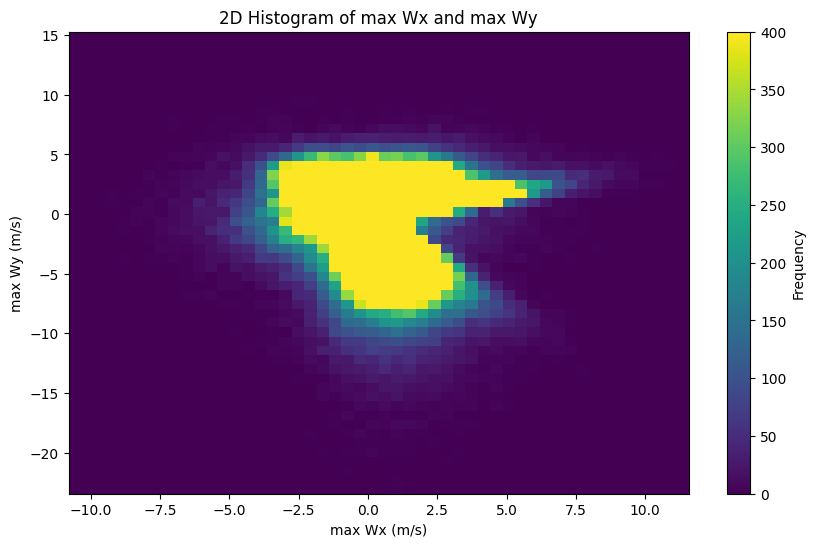

In [19]:
# Create a 2D histogram for wind direction and wind velocity
plt.figure(figsize=(10, 6))
plt.hist2d(data['max Wx'], data['max Wy'], bins=(50, 50), vmax=400, cmap='viridis')
plt.colorbar(label='Frequency')
plt.xlabel('max Wx (m/s)')
plt.ylabel('max Wy (m/s)')
plt.title('2D Histogram of max Wx and max Wy')
plt.show()

In [20]:
# Set 'Datetime' as the index
data.set_index('Datetime', inplace=True)

# Extract the hour of the day and the day of the week
data['hour_of_day'] = data.index.hour
data['day_of_week'] = data.index.dayofweek

# Apply sine and cosine transformations for the hour of the day (daily cycle)
data['sin_hour'] = np.sin(2 * np.pi * data['hour_of_day'] / 24)
data['cos_hour'] = np.cos(2 * np.pi * data['hour_of_day'] / 24)

# Apply sine and cosine transformations for the day of the week (weekly cycle)
data['sin_day'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['cos_day'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

data.reset_index(inplace=True)


# Display the new columns to verify
print(data[['hour_of_day', 'day_of_week', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day']].head())

   hour_of_day  day_of_week  sin_hour  cos_hour   sin_day   cos_day
0            0            2       0.0       1.0  0.974928 -0.222521
1            0            2       0.0       1.0  0.974928 -0.222521
2            0            2       0.0       1.0  0.974928 -0.222521
3            0            2       0.0       1.0  0.974928 -0.222521
4            0            2       0.0       1.0  0.974928 -0.222521


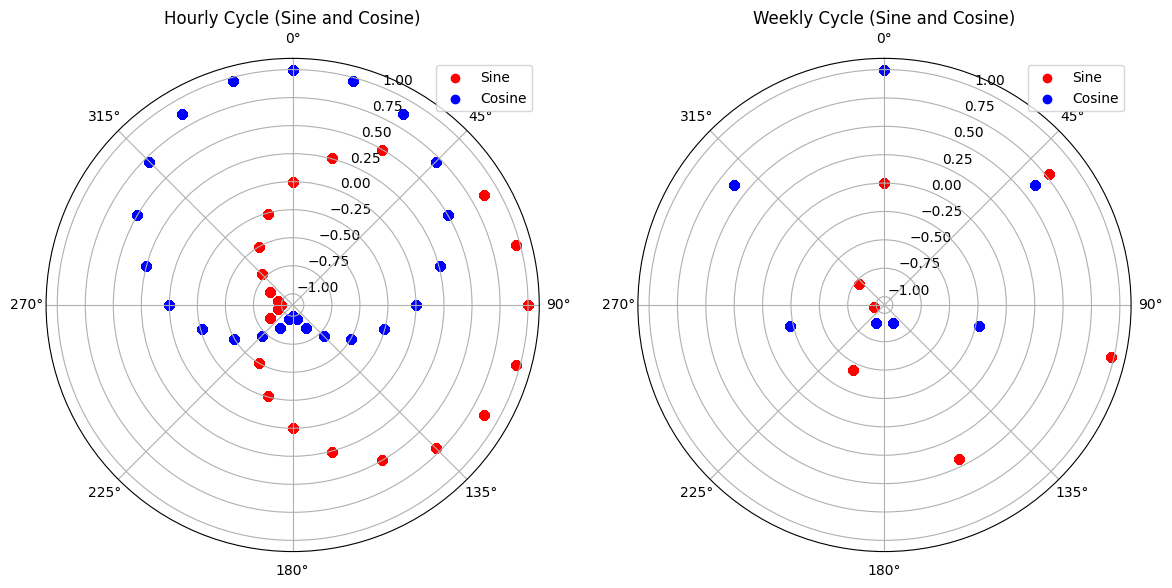

In [21]:


# Set 'Datetime' as the index if not already
data.set_index('Datetime', inplace=True)

# Create polar plots for hourly and weekly cycles
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 7))

# Hourly cycle
angles_hours = 2 * np.pi * data['hour_of_day'] / 24
axes[0].scatter(angles_hours, data['sin_hour'], color='red', label='Sine')
axes[0].scatter(angles_hours, data['cos_hour'], color='blue', label='Cosine')
axes[0].set_title('Hourly Cycle (Sine and Cosine)')
axes[0].set_theta_zero_location('N')
axes[0].set_theta_direction(-1)
axes[0].legend()

# Weekly cycle
angles_days = 2 * np.pi * data['day_of_week'] / 7
axes[1].scatter(angles_days, data['sin_day'], color='red', label='Sine')
axes[1].scatter(angles_days, data['cos_day'], color='blue', label='Cosine')
axes[1].set_title('Weekly Cycle (Sine and Cosine)')
axes[1].set_theta_zero_location('N')
axes[1].set_theta_direction(-1)
axes[1].legend()

plt.show()

data.reset_index(inplace=True)


In [22]:
count_negative_values = data[data['Snow Depth [cm]'] < -200].shape[0]
print("Number of rows with snow depth less than -200:", count_negative_values)

Number of rows with snow depth less than -200: 272


In [23]:
# Convert all values in 'Snow Depth [cm]' that are less than -200 to -28
data['Snow Depth [cm]'] = data['Snow Depth [cm]'].apply(lambda x: -28 if x < -200 else x)

smallest_snow_depth = data['Snow Depth [cm]'].min()
print("Smallest value in the Snow Depth [cm] column:", smallest_snow_depth)

Smallest value in the Snow Depth [cm] column: -28.0


In [24]:
# Columns to drop
columns_to_drop = ['Datetime', 'DATE (MM/DD)', 'MST', 'Formatted Date',"Azimuth Angle [degrees]","Peak Wind Speed @ 6ft [m/s]","Avg Wind Direction @ 6ft [deg from N]","Week","Month","hour_of_day","day_of_week","Precipitation (Accumulated) [mm]"]

# Drop the columns
df = data.drop(columns=columns_to_drop)

# Display the first few rows of the cleaned dataset to verify
df

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Station Pressure [mBar],Snow Depth [cm],Moisture,Albedo (CMP11),sin_azimuth,cos_azimuth,max Wx,max Wy,sin_hour,cos_hour,sin_day,cos_day
0,-0.962276,0.000000,7.216,0.988,-7.312,32.33,0.0,806.779,0.219,0.0,0.0,-0.054839,0.998495,0.225739,-9.947439,0.000000,1.000000,0.974928,-0.222521
1,-0.937921,0.000000,7.251,1.040,-7.260,32.40,0.0,806.840,0.206,0.0,0.0,-0.040916,0.999163,0.414862,-8.189499,0.000000,1.000000,0.974928,-0.222521
2,-0.944395,0.000000,7.256,1.093,-7.207,32.54,0.0,806.876,0.148,0.0,0.0,-0.026973,0.999636,2.159180,-6.342550,0.000000,1.000000,0.974928,-0.222521
3,-0.951350,-0.029673,7.254,1.060,-7.440,31.89,0.0,806.823,0.235,0.0,0.0,-0.013017,0.999915,3.131872,-7.034300,0.000000,1.000000,0.974928,-0.222521
4,-0.934976,-0.054401,7.331,1.081,-7.419,31.78,0.0,806.762,0.182,0.0,0.0,0.000945,1.000000,1.924116,-6.938139,0.000000,1.000000,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482395,-1.430090,-0.098754,6.093,-1.134,-14.734,17.95,0.0,812.627,0.163,0.0,0.0,0.068346,0.997662,0.829863,-2.569305,-0.258819,0.965926,0.000000,1.000000
482396,-1.423050,-0.153069,6.035,-1.314,-15.614,16.61,0.0,812.623,0.262,0.0,0.0,0.081450,0.996677,1.260614,-2.941233,-0.258819,0.965926,0.000000,1.000000
482397,-1.366740,-0.098754,6.207,-1.326,-16.126,15.65,0.0,812.616,0.359,0.0,0.0,0.094520,0.995523,1.015806,-2.501627,-0.258819,0.965926,0.000000,1.000000
482398,-1.353470,-0.044439,6.357,-1.097,-15.297,16.73,0.0,812.614,0.172,0.0,0.0,0.107550,0.994200,1.232708,-2.680099,-0.258819,0.965926,0.000000,1.000000


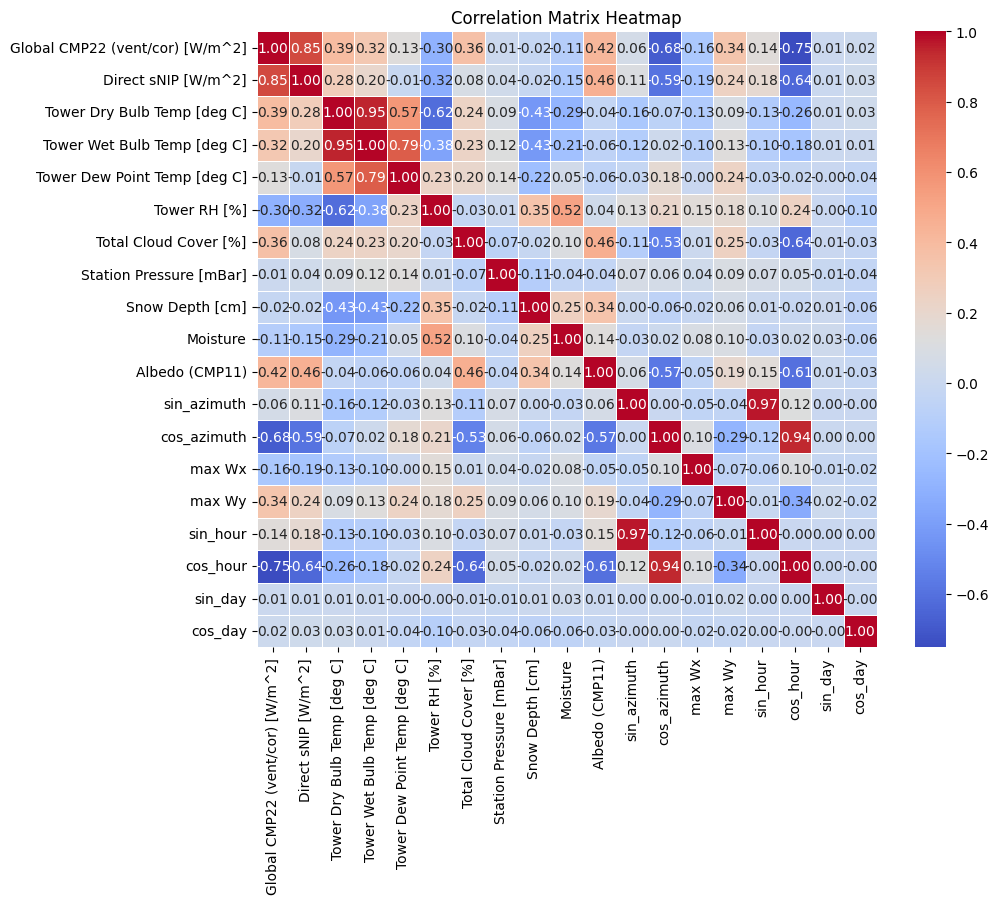

In [25]:
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [26]:
df.to_csv('3.csv', index=False)


In [ ]:
# Done